## First similarity study -> Collaborative filtering with different formulas for distance

#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

#### Loading the datasources

In [3]:
electionDetailsDF = pd.read_csv('projectDetails.csv', sep=";")
print("Election details",electionDetailsDF.columns,"\n")

Election details Index(['ID', 'project_id', 'project_title', 'created_at', 'checked_out_at',
       'project_url', 'vote_finished'],
      dtype='object') 



In [4]:
##Creating the binary matrix
voter_matrix = pd.crosstab(electionDetailsDF['ID'], electionDetailsDF['project_id'])

print(voter_matrix)

project_id  4    5    6    7    8    9    10   11   12   13   ...  194  195  \
ID                                                            ...             
9             0    0    0    0    0    0    0    0    0    0  ...    0    0   
11            0    0    0    0    0    0    0    0    0    0  ...    0    0   
12            0    0    0    0    0    0    0    0    0    0  ...    0    0   
13            0    1    0    0    0    0    0    0    0    0  ...    0    0   
15            0    0    0    0    0    0    0    0    0    0  ...    0    0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5228          0    0    0    0    0    0    0    0    0    0  ...    0    0   
5229          0    0    0    1    0    0    0    1    0    0  ...    0    0   
5230          0    0    0    0    0    0    0    0    0    0  ...    0    0   
5231          0    0    0    0    0    0    0    0    0    0  ...    0    0   
5232          0    0    0    0    0    0    0    0  

**Item-item collaborative filtering**

In [5]:
##Magnitude vector to apply normalization
magnitude = np.sqrt(np.square(voter_matrix).sum(axis=1))

##Unit vector (normalized matrix)
voter_matrix = voter_matrix.divide(magnitude, axis='index')

def calculate_similarity_cosine(data_items):
    """
    Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index = data_items.columns, columns=data_items.columns)
    return sim

def calculate_similarity_jaccard(data_items):
    """
    Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    distances = pdist(data_items, metric='jaccard')
    similarities = 1 - squareform(distances)
    return pd.DataFrame(similarities, index=data_items.index, columns=data_items.index)

def calculate_similarity_pearson(data_items):
    """
    Calculate the column-wise pearson similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    similarities = data_items.corr(method='pearson')
    return similarities

def calculate_similarity_euclidean(data_items):
    """
    Calculate Euclidean distance and convert to similarity.
    Similarity = 1 / (1 + distance)
    """
    distances = pdist(data_items.T, metric='euclidean')
    similarities = 1 / (1 + squareform(distances))
    return pd.DataFrame(similarities, index=data_items.columns, columns=data_items.columns)

def calculate_similarity_manhattan(data_items):
    distances = pdist(data_items.T, metric='cityblock')
    similarities = 1 / (1 + squareform(distances))
    return pd.DataFrame(similarities, index=data_items.columns, columns=data_items.columns)

def calculate_similarity_tanimoto(data_items):
    """
    Generalized Jaccard (Tanimoto) similarity for non-binary data.
    """
    A = data_items.values.T
    dot_product = A @ A.T
    square_sum = np.sum(A ** 2, axis=1).reshape(-1, 1)
    denominator = square_sum + square_sum.T - dot_product
    similarity = dot_product / (denominator + 1e-10)
    return pd.DataFrame(similarity, index=data_items.columns, columns=data_items.columns)

def calculate_similarity_adjusted_cosine(data_items):
    """
    Adjusted cosine similarity - subtract mean user rating before computing cosine similarity.
    """
    mean_user_ratings = data_items.mean(axis=1)
    adjusted_data = data_items.sub(mean_user_ratings, axis=0).fillna(0)
    data_sparse = sparse.csr_matrix(adjusted_data)
    similarities = cosine_similarity(data_sparse.T)
    return pd.DataFrame(similarities, index=data_items.columns, columns=data_items.columns)

def calculate_similarity_hamming(data_items):
    """
    Calculate Hamming similarity (1 - Hamming distance) between columns (items).
    Assumes binary data.
    """
    # Transpose so we're comparing items (columns)
    distances = pdist(data_items.T, metric='hamming')
    similarities = 1 - squareform(distances)
    return pd.DataFrame(similarities, index=data_items.columns, columns=data_items.columns)

def compare_similarity_metrics(data_items,project_id,top_n=11):
    cosine = calculate_similarity_cosine(voter_matrix)
    jaccard = calculate_similarity_jaccard(voter_matrix)
    pearson = calculate_similarity_pearson(voter_matrix)
    euclidean = calculate_similarity_euclidean(voter_matrix)
    manhattan = calculate_similarity_manhattan(voter_matrix)
    tanimoto = calculate_similarity_tanimoto(voter_matrix)
    hamming = calculate_similarity_hamming(voter_matrix)

    similarity_comparator = {
        "cosine":list(cosine.loc[project_id].nlargest(top_n).round(4).items())[1:],
        #"jaccard":list(jaccard.loc[project_id].nlargest(top_n).round(4).items()),
        "pearson":list(pearson.loc[project_id].nlargest(top_n).round(4).items())[1:],
        "euclidean":list(euclidean.loc[project_id].nlargest(top_n).round(4).items())[1:],
        "manhattan":list(manhattan.loc[project_id].nlargest(top_n).round(4).items())[1:],
        "tanimoto":list(tanimoto.loc[project_id].nlargest(top_n).round(4).items())[1:],
        "hamming":list(hamming.loc[project_id].nlargest(top_n).round(4).items())[1:]
    }

    return pd.DataFrame(similarity_comparator)
    
print(compare_similarity_metrics(voter_matrix, 84))


          cosine        pearson      euclidean      manhattan       tanimoto  \
0    (87, 0.677)   (87, 0.6731)   (87, 0.2109)   (87, 0.0524)   (87, 0.5116)   
1   (86, 0.6361)   (86, 0.6313)   (86, 0.2008)     (86, 0.04)   (86, 0.4663)   
2   (90, 0.1316)   (90, 0.1245)   (50, 0.1736)    (50, 0.026)   (90, 0.0656)   
3   (81, 0.0966)   (81, 0.0889)  (176, 0.1736)   (176, 0.026)   (81, 0.0455)   
4    (82, 0.087)   (82, 0.0777)  (187, 0.1736)   (187, 0.026)   (82, 0.0441)   
5   (89, 0.0742)   (89, 0.0697)  (181, 0.1731)  (181, 0.0259)   (83, 0.0317)   
6   (83, 0.0658)   (83, 0.0578)   (55, 0.1725)  (178, 0.0257)   (89, 0.0267)   
7  (186, 0.0355)  (186, 0.0305)  (168, 0.1725)   (55, 0.0256)   (186, 0.013)   
8   (74, 0.0221)   (183, 0.014)   (46, 0.1715)  (168, 0.0256)   (74, 0.0104)   
9  (183, 0.0214)   (74, 0.0131)  (178, 0.1715)   (46, 0.0252)  (183, 0.0102)   

         hamming  
0   (87, 0.9945)  
1   (86, 0.9916)  
2   (50, 0.9861)  
3  (176, 0.9861)  
4  (178, 0.9861)  
5  (1

In [40]:
df_cosine_similarity_matrix = calculate_similarity_cosine(voter_matrix)
df_pearson_similarity_matrix = calculate_similarity_pearson(voter_matrix)
df_euclidean_similarity_matrix = calculate_similarity_euclidean(voter_matrix)
df_manhattan_similarity_matrix = calculate_similarity_manhattan(voter_matrix)
df_tanimoto_similarity_matrix = calculate_similarity_tanimoto(voter_matrix)
df_hamming_similarity_matrix = calculate_similarity_hamming(voter_matrix)

similarity_plot_list = [df_cosine_similarity_matrix, df_pearson_similarity_matrix, 
                        df_euclidean_similarity_matrix, df_manhattan_similarity_matrix,
                        df_tanimoto_similarity_matrix, df_hamming_similarity_matrix]
distance_names = ["cosine","pearson","euclidean","manhattan","tanimoto","hamming"]

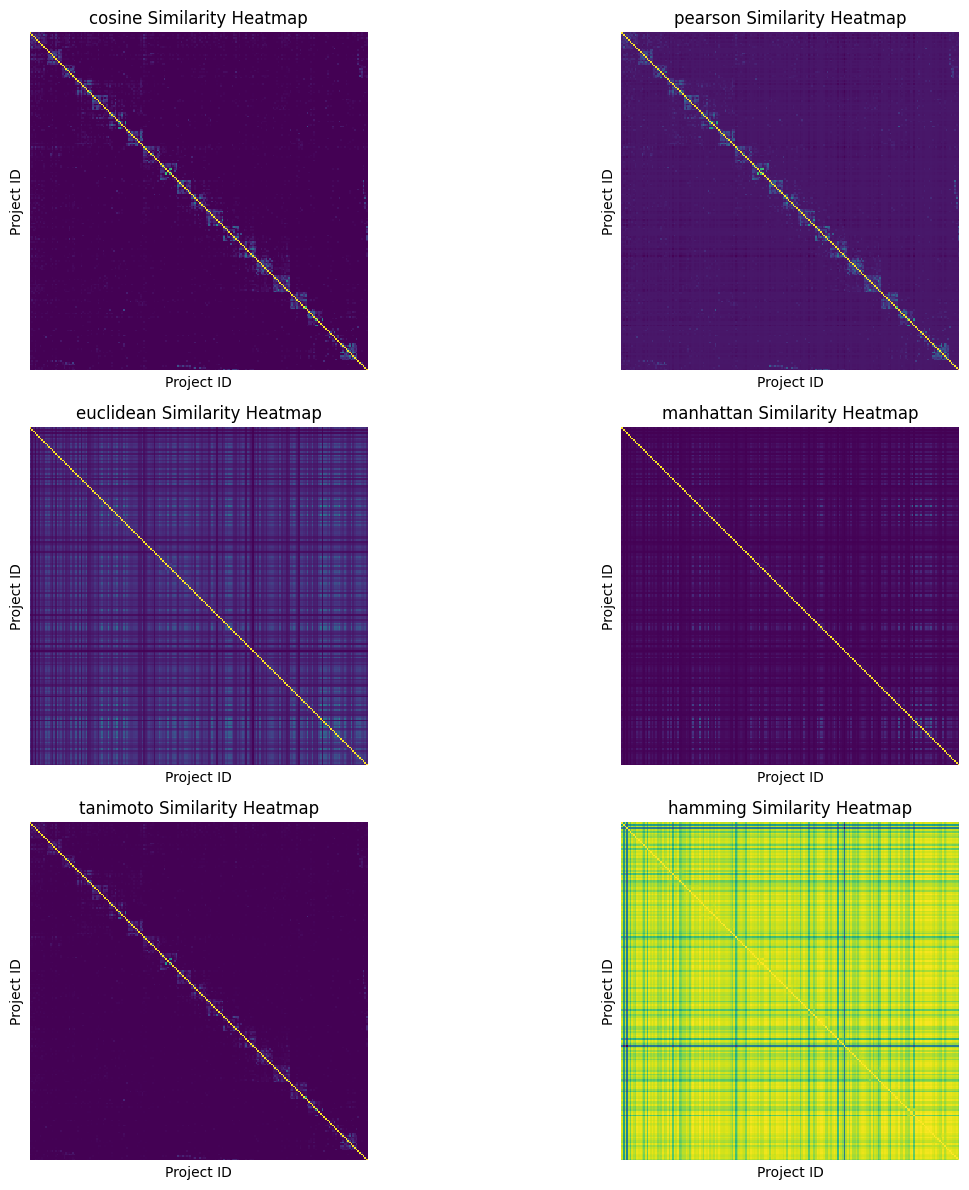

In [43]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))  # Adjust size as needed

# Flatten the 2D axes array to iterate easily
axes = axes.flatten()

# Plot each heatmap
for i, similarity_plot_df in enumerate(similarity_plot_list):
    ax = axes[i]
    sns.heatmap(similarity_plot_df, cmap='viridis', square=True, ax=ax, cbar=False)
    
    ax.set_title(f'{distance_names[i]} Similarity Heatmap (item-item collaborative)')
    ax.set_xlabel('Project ID')
    ax.set_ylabel('Project ID')
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused subplots (in case there are fewer than 6)
for j in range(len(similarity_plot_list), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

**Heatmap for cosine similarity**

#### Checking the highest similarity using only distance

In [11]:
# project_ids=list(voter_matrix.columns)
# h_cosine={
#     "project_id":0,
#     "sim_val":0,
#     "most_sim_project_id":0
# }
# # h_jaccard={
# #     "sim_val":0,
# #     "project_id":0
# # }
# h_pearson={
#     "project_id":0,
#     "sim_val":0,
#     "most_sim_project_id":0
# }
# h_euclidean={
#     "project_id":0,
#     "sim_val":0,
#     "most_sim_project_id":0
# }
# h_manhattan={
#     "project_id":0,
#     "sim_val":0,
#     "most_sim_project_id":0
# }
# h_tanimoto={
#     "project_id":0,
#     "sim_val":0,
#     "most_sim_project_id":0
# }
# h_hamming={
#     "project_id":0,
#     "sim_val":0,
#     "most_sim_project_id":0
# }

# for project_id in project_ids:
#     # print(project_id)
#     similarities = compare_similarity_metrics(voter_matrix,project_id,top_n=2)
#     #print(similarities)
#     cosine = similarities['cosine']
#     pearson = similarities['pearson']
#     euclidean = similarities['euclidean']
#     manhattan = similarities['manhattan']
#     tanimoto = similarities['tanimoto']
#     hamming = similarities['hamming']

#     ##Check cosine highest
#     if cosine[0][1] > h_cosine['sim_val']:
#         h_cosine['project_id']=project_id
#         h_cosine['sim_val'] = cosine[0][1]
#         h_cosine['most_sim_project_id']=cosine[0][0]

#     ##Check pearson highest
#     if pearson[0][1] > h_pearson['sim_val']:
#         h_pearson['project_id']=project_id
#         h_pearson['sim_val'] = pearson[0][1]
#         h_pearson['most_sim_project_id']=pearson[0][0]

#     ##Check euclidean highest
#     if euclidean[0][1] > h_euclidean['sim_val']:
#         h_euclidean['project_id']=project_id
#         h_euclidean['sim_val'] = euclidean[0][1]
#         h_euclidean['most_sim_project_id']=euclidean[0][0]

#     ##Check manhattan highest
#     if manhattan[0][1] > h_manhattan['sim_val']:
#         h_manhattan['project_id']=project_id
#         h_manhattan['sim_val'] = manhattan[0][1]
#         h_manhattan['most_sim_project_id']=manhattan[0][0]

#     ##Check tanimoto highest
#     if tanimoto[0][1] > h_tanimoto['sim_val']:
#         h_tanimoto['project_id']=project_id
#         h_tanimoto['sim_val'] = tanimoto[0][1]
#         h_tanimoto['most_sim_project_id']=tanimoto[0][0]

#     ##Check hamming highest
#     if hamming[0][1] > h_hamming['sim_val']:
#         h_hamming['project_id']=project_id
#         h_hamming['sim_val'] = hamming[0][1]
#         h_hamming['most_sim_project_id']=hamming[0][0]

#     # if project_id == 5:
#     #     break


In [12]:
# # print(project_ids)
# print(h_cosine)
# print(h_pearson)
# print(h_euclidean)
# print(h_manhattan)
# print(h_tanimoto)
# print(h_hamming)

With the result of the comparison code written 2 blocks up (they are commented because it takes a long time to run them): 
```
cosine -> {'project_id': 84, 'sim_val': 0.677, 'most_sim_project_id': 87}
pearson -> {'project_id': 84, 'sim_val': 0.6731, 'most_sim_project_id': 87}
euclidean -> {'project_id': 50, 'sim_val': 0.4641, 'most_sim_project_id': 176}
manhattan -> {'project_id': 50, 'sim_val': 0.3022, 'most_sim_project_id': 176}
tanimoto -> {'project_id': 84, 'sim_val': 0.5116, 'most_sim_project_id': 87}
hamming -> {'project_id': 50, 'sim_val': 0.9991, 'most_sim_project_id': 176}
```

We can see that cosine, pearson and tanimoto produces the same results with different intensities. This is also the case for euclidean, manhattan and hamming

## Second similarity study -> calculating distances after embedding

The idea of this second study is to test the performance of different embedding techniques and check their performance regarding project similarity:  
1. TF-IDF
2. Word2Vec
3. BERT family
4. GPT Family

### TF-IDF

In [13]:
## Imports
from typing import List
from unidecode import unidecode
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### tokenization of documents(description)

In [14]:
##Function to generate tokens via a given text
def tokenize(text: str) -> List[str]:
    ##Text without any accents
    unidecoded_text = unidecode(text)
    ## Remove punctuation
    cleaned_text = re.sub(r"[^\w\s]", " ", unidecoded_text)

    #Split cleaned text into words
    tokens = cleaned_text.lower().split()
    return tokens

#### Data loading

In [15]:
electionAggregateDF = pd.read_csv('projectsAgg2.csv', sep=";")
print("Aggregated dataframe ",electionAggregateDF.columns,"\n")

Aggregated dataframe  Index(['project_id', 'project_name', 'description', 'category', 'cost',
       'district', 'votes'],
      dtype='object') 



**Testing the tokenizer**

In [16]:
##Checking tokenizer
doc_test = tokenize(electionAggregateDF.iloc[0].description)
print(electionAggregateDF.iloc[0].description)
print(doc_test)
print(len(doc_test))

Mise en place de pièges à moustiques dans le quartier du Pont des Demoiselles: Capture des moustiques par aspiration grâce à des bornes/pièges (obturateurs) made in France simulant l'odeur humaine. Système respectueux de l'environnement.Modalités de réalisation - Avis technique :Installation de trois bornes “anti-moustiques” au sein du quartier Pont des Demoiselles. Ces bornes combinent deux facteurs : 1) La diffusion lente de CO² 2) Les composés organiques volatiles. En plus de leur efficacité, ces bornes ont également l'avantage de respecter la biodiversité. Elles seront placées aux abords des équipements publics.
['mise', 'en', 'place', 'de', 'pieges', 'a', 'moustiques', 'dans', 'le', 'quartier', 'du', 'pont', 'des', 'demoiselles', 'capture', 'des', 'moustiques', 'par', 'aspiration', 'grace', 'a', 'des', 'bornes', 'pieges', 'obturateurs', 'made', 'in', 'france', 'simulant', 'l', 'odeur', 'humaine', 'systeme', 'respectueux', 'de', 'l', 'environnement', 'modalites', 'de', 'realisation

**Creating a dictionary of tokenized documents**

In [17]:
##Creating a dict of tokenized documents
tokenized_descriptions = [tokenize(x) for x in electionAggregateDF.description]

print(tokenized_descriptions[0])

['mise', 'en', 'place', 'de', 'pieges', 'a', 'moustiques', 'dans', 'le', 'quartier', 'du', 'pont', 'des', 'demoiselles', 'capture', 'des', 'moustiques', 'par', 'aspiration', 'grace', 'a', 'des', 'bornes', 'pieges', 'obturateurs', 'made', 'in', 'france', 'simulant', 'l', 'odeur', 'humaine', 'systeme', 'respectueux', 'de', 'l', 'environnement', 'modalites', 'de', 'realisation', 'avis', 'technique', 'installation', 'de', 'trois', 'bornes', 'anti', 'moustiques', 'au', 'sein', 'du', 'quartier', 'pont', 'des', 'demoiselles', 'ces', 'bornes', 'combinent', 'deux', 'facteurs', '1', 'la', 'diffusion', 'lente', 'de', 'co2', '2', 'les', 'composes', 'organiques', 'volatiles', 'en', 'plus', 'de', 'leur', 'efficacite', 'ces', 'bornes', 'ont', 'egalement', 'l', 'avantage', 'de', 'respecter', 'la', 'biodiversite', 'elles', 'seront', 'placees', 'aux', 'abords', 'des', 'equipements', 'publics']


**Creating the corpus (dictionary of all words in the description dataset)**

In [18]:
##Creating the total corpus and feeding it with the data
total_description_corpus = set()

for description_text in electionAggregateDF.description:
    preprocessed_description = tokenize(description_text)
    total_description_corpus.update(set(preprocessed_description))

print(len(total_description_corpus))

5117


**Dictionary generation of word frequency in a given document**

In [19]:
##Function to produce a dictionary based on the word frequency of the document
def generate_freq_dict(total_corpus: dict, tokenized_document: list[str] ) -> dict:
    word_count = dict.fromkeys(total_corpus,0)

    for word in tokenized_document:
        word_count[word] += 1

    return word_count

In [20]:
##Test the generated dictionary
word_count_document_test = generate_freq_dict(total_description_corpus, doc_test)
# print(word_count_document_test)

**Generation of a list of dictionaries with all the word counts over the total words in the dataframe per description**

In [21]:
processed_documents_word_counts = [generate_freq_dict(total_description_corpus, tokenized_description) for tokenized_description in tokenized_descriptions]

#### Calculation of term frequency

In [22]:
def tf(word_counts: dict, tokenized_document: list[str]) -> dict:
    """Calculate term frequency of each word in a document."""
    tf_dict = {}
    corpus_count = len(tokenized_document)

    for word, count in word_counts.items():
        tf_dict[word] = count / float(corpus_count)

    return tf_dict

In [23]:
tf_doc_test = tf(word_count_document_test, doc_test)
# print(tf_doc_test)

#### Calculation of idf (execution per document)

In [24]:
def idf(word_counts: list[dict[str, int]]) -> dict:
    """Given N documents, no. of documents in which the the term appears for each term"""
    idf_dict = {}
    N = len(word_counts)

    idf_dict = dict.fromkeys(word_counts[0].keys(), 0)

    for word in idf_dict.keys():
        idf_dict[word] = sum(doc[word] > 0  for doc in word_counts)

    for word, df in idf_dict.items():
        idf_dict[word] = np.log10((N+1.0)/(df+1.0))

    return idf_dict

In [25]:
print(type(processed_documents_word_counts[0]))
idfs = idf(processed_documents_word_counts)
len(idfs)

<class 'dict'>


5117

#### Calculation of tfidf per document

In [26]:
def tfidf(doc_elements: dict[str, int], idfs: dict[str, int]) -> dict:
    """TF * IDF per word given a single word in a single document"""
    tfidf_dict = {}

    for word, val in doc_elements.items():
        tfidf_dict[word] = val*idfs[word]

    return tfidf_dict

In [27]:
tfidf_doc_test = tfidf(tf_doc_test, idfs)
# print(tfidf_doc_test)

#### Applying L2 normalization on the tfidf vector

In [28]:
def l2_normalize(tfidf_vector: dict[str, float]) -> dict[str, float]:
    norm = np.sqrt(sum(val**2 for val in tfidf_vector.values()))
    if norm == 0:
        return tfidf_vector  # prevent division by zero
    return {word: val / norm for word, val in tfidf_vector.items()}

**Normalization sanity check**

In [29]:
normalized_tfidf_vector = l2_normalize(tfidf_doc_test)

vec = list(normalized_tfidf_vector.values())
norm_check = np.linalg.norm(vec)
print(norm_check)

0.9999999999999999


**Creating the tfidf matrix for the description**

In [30]:
##Create a sorted vocabulary list for matrix consistency
vocab_list = sorted(list(total_description_corpus))

##associate a index with a word in the vocab_list
word_index = {word: i for i, word in enumerate(vocab_list)}

##Matrix initialization
num_docs = len(electionAggregateDF.description)
num_words = len(vocab_list)
tfidf_matrix = np.zeros((num_docs,num_words))

for doc_idx, tokenized_doc in enumerate(tokenized_descriptions):
    word_counts = generate_freq_dict(total_description_corpus, tokenized_doc)
    tf_vector = tf(word_counts, tokenized_doc)
    tfidf_vector = tfidf(tf_vector, idfs)
    normalized = l2_normalize(tfidf_vector)

    for word, value in normalized.items():
        col_idx = word_index[word]
        tfidf_matrix[doc_idx][col_idx] = value

print(tfidf_matrix.shape)

##Creating a dataframe based on the matrix
content_tfidf_matrix = pd.DataFrame(tfidf_matrix, columns = vocab_list)
project_ids = electionAggregateDF["project_id"].tolist()
content_tfidf_matrix["project_id"] = project_ids
content_tfidf_matrix.set_index("project_id",inplace=True)
print(content_tfidf_matrix)

(199, 5117)
              0       000  000eur   01   02   09         1   10  100  1000  \
project_id                                                                   
132         0.0  0.000000     0.0  0.0  0.0  0.0  0.074695  0.0  0.0   0.0   
78          0.0  0.000000     0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0   
122         0.0  0.000000     0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0   
149         0.0  0.041375     0.0  0.0  0.0  0.0  0.044763  0.0  0.0   0.0   
129         0.0  0.000000     0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0   
...         ...       ...     ...  ...  ...  ...       ...  ...  ...   ...   
98          0.0  0.173220     0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0   
88          0.0  0.000000     0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0   
109         0.0  0.000000     0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0   
131         0.0  0.000000     0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0   
32          0.0  0.000000     0.0  0.0  0.0  0.0  0.

**Creating the tfidf matrix for the title**

In [64]:
##Creating the total corpus and feeding it with the data
total_title_corpus = set()

for title_text in electionAggregateDF.project_name:
    preprocessed_title = tokenize(title_text)
    total_title_corpus.update(set(preprocessed_title))

print(len(total_title_corpus))

tokenized_titles = [tokenize(x) for x in electionAggregateDF.project_name]

processed_documents_titles_word_counts = [
    generate_freq_dict(total_title_corpus, tokenized_title) for tokenized_title in tokenized_titles
]

title_idfs = idf(processed_documents_word_counts)


612


In [65]:
##Create a sorted vocabulary list for matrix consistency
title_vocab_list = sorted(list(total_title_corpus))

##associate a index with a word in the vocab_list
word_index = {word: i for i, word in enumerate(title_vocab_list)}

##Matrix initialization
num_docs_title = len(electionAggregateDF.project_name)
num_words_title = len(title_vocab_list)
tfidf_title_matrix = np.zeros((num_docs_title,num_words_title))

for doc_idx, tokenized_doc in enumerate(tokenized_titles):
    word_counts = generate_freq_dict(total_title_corpus, tokenized_doc)
    tf_vector = tf(word_counts, tokenized_doc)
    tfidf_vector = tfidf(tf_vector, title_idfs)
    normalized = l2_normalize(tfidf_vector)

    for word, value in normalized.items():
        col_idx = word_index[word]
        tfidf_matrix[doc_idx][col_idx] = value

print(tfidf_matrix.shape)

##Creating a dataframe based on the matrix
title_tfidf_matrix = pd.DataFrame(tfidf_title_matrix, columns = title_vocab_list)
project_ids = electionAggregateDF["project_id"].tolist()
title_tfidf_matrix["project_id"] = project_ids
title_tfidf_matrix.set_index("project_id",inplace=True)
print(title_tfidf_matrix)

KeyError: 'captation'

In [31]:
tfidf_cosine_similarity_matrix = cosine_similarity(content_tfidf_matrix)

df_tfidf_similarity = pd.DataFrame(tfidf_cosine_similarity_matrix, index=project_ids, columns=project_ids)


In [32]:
print(df_tfidf_similarity)

          132       78        122       149       129       77        82   \
132  1.000000  0.008972  0.006654  0.027580  0.004174  0.036862  0.014026   
78   0.008972  1.000000  0.094344  0.037482  0.019138  0.034900  0.030278   
122  0.006654  0.094344  1.000000  0.014674  0.030818  0.102617  0.018739   
149  0.027580  0.037482  0.014674  1.000000  0.006470  0.056773  0.015435   
129  0.004174  0.019138  0.030818  0.006470  1.000000  0.024085  0.001727   
..        ...       ...       ...       ...       ...       ...       ...   
98   0.050083  0.019598  0.013200  0.032151  0.043428  0.016600  0.046291   
88   0.009327  0.016712  0.020135  0.025049  0.001505  0.023242  0.048935   
109  0.016901  0.043395  0.035653  0.019422  0.004482  0.019034  0.006417   
131  0.064761  0.007830  0.008964  0.033298  0.000951  0.018343  0.024258   
32   0.004251  0.023095  0.073201  0.017627  0.013780  0.043614  0.031076   

          45        181       95   ...       188       166       128  \
132

In [51]:
# sns.clustermap(tfidf_tanimoto_similarity_matrix, cmap='viridis', figsize=(15, 15))
# plt.show()

tfidf_cosine_similarity_matrix = calculate_similarity_cosine(df_tfidf_similarity)
tfidf_pearson_similarity_matrix = calculate_similarity_pearson(df_tfidf_similarity)
tfidf_euclidean_similarity_matrix = calculate_similarity_euclidean(df_tfidf_similarity)
tfidf_manhattan_similarity_matrix = calculate_similarity_manhattan(df_tfidf_similarity)
tfidf_tanimoto_similarity_matrix = calculate_similarity_tanimoto(df_tfidf_similarity)
tfidf_hamming_similarity_matrix = calculate_similarity_hamming(df_tfidf_similarity)

tfidf_similarity_plot_list = [tfidf_cosine_similarity_matrix,tfidf_pearson_similarity_matrix,
                        tfidf_euclidean_similarity_matrix,tfidf_manhattan_similarity_matrix,
                        tfidf_tanimoto_similarity_matrix,tfidf_hamming_similarity_matrix]

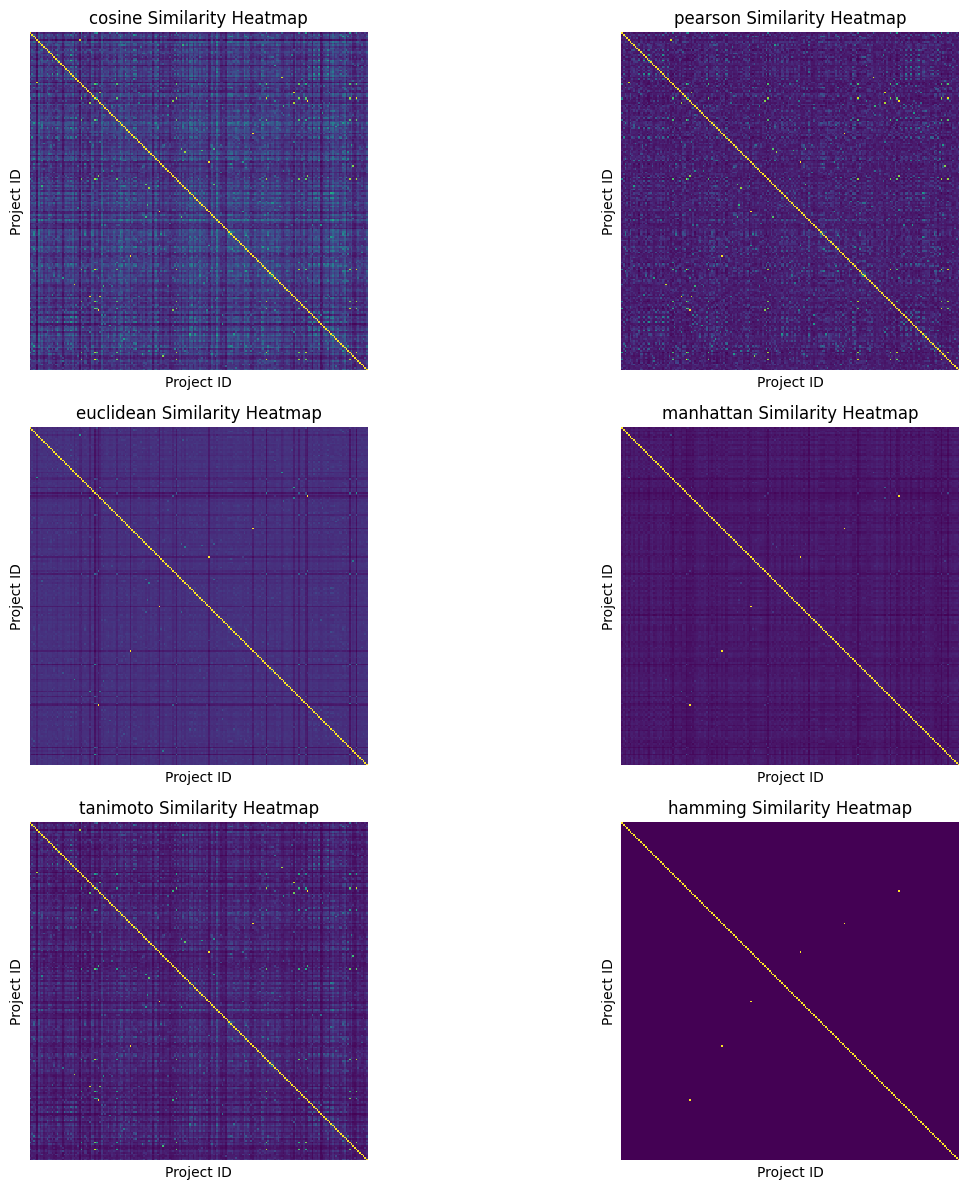

In [53]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))  # Adjust size as needed

# Flatten the 2D axes array to iterate easily
axes = axes.flatten()

# Plot each heatmap
for i, similarity_plot_df in enumerate(tfidf_similarity_plot_list):
    ax = axes[i]
    sns.heatmap(similarity_plot_df, cmap='viridis', square=True, ax=ax, cbar=False)
    
    ax.set_title(f'{distance_names[i]} Similarity Heatmap (descritpion)')
    ax.set_xlabel('Project ID')
    ax.set_ylabel('Project ID')
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(len(similarity_plot_list), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [58]:
cosine_sim_no_diag = tfidf_cosine_similarity_matrix.copy()
for idx in cosine_sim_no_diag.index:
    cosine_sim_no_diag.loc[idx, idx] = -1  # or np.nan if you prefer

# Find the most similar project for each project
most_similar_projects = cosine_sim_no_diag.idxmax(axis=1)  # index of most similar
similarity_scores = cosine_sim_no_diag.max(axis=1)          # corresponding similarity score

# Create the subset DataFrame
result_df = pd.DataFrame({
    'Project': cosine_sim_no_diag.index,
    'Most_Similar_Project': most_similar_projects,
    'Similarity_Score': similarity_scores
}).reset_index(drop=True)

print(result_df.sort_values(by='Similarity_Score', ascending=False).head(10))

     Project  Most_Similar_Project  Similarity_Score
76       179                   202          1.000000
105      202                   179          1.000000
40       200                   165          1.000000
163      165                   200          1.000000
131      114                   203          1.000000
59       203                   114          1.000000
38        17                    94          0.962456
192       94                    17          0.962456
35       199                   198          0.956195
155      198                   199          0.956195
